### Финальный проект по временными рядам
### Покумин Георгий Алексеевич

#### Блок предобратки временного ряда и получения его характеристик

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
from math import sqrt
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data

In [3]:
timeseries = pd.read_csv("weather_data.csv")
timeseries['Date'] = pd.to_datetime(timeseries['Year'].astype(str) + timeseries['Day'].astype(str), format='%Y%j')
timeseries = timeseries.drop(columns=["Year", "Day"])

In [ ]:
timeseries.head()

,Wind Speed,Specific Humidity,Relative Humidity,Precipitation,Temperature,Date
0,1.08,5.68,53.06,0.0,16.33,1990-01-01
1,1.13,5.92,58.06,0.0,15.68,1990-01-02
2,1.33,5.68,52.69,0.0,16.56,1990-01-03
3,1.09,5.19,47.19,0.0,17.09,1990-01-04
4,0.94,4.82,42.88,0.0,17.26,1990-01-05


Датасет представляет из себя информацию о погоде в Бангладеше с 1990 по 2023 год. Столбцы - скорость ветра, удельная влажность, относительная влажность, количество осадков, температура.

Сделаем время индексом.

In [4]:
timeseries = timeseries.set_index('Date').sort_index()
timeseries.head()

,Wind Speed,Specific Humidity,Relative Humidity,Precipitation,Temperature
Date,,,,,
1990-01-01,1.08,5.68,53.06,0.0,16.33
1990-01-02,1.13,5.92,58.06,0.0,15.68
1990-01-03,1.33,5.68,52.69,0.0,16.56
1990-01-04,1.09,5.19,47.19,0.0,17.09
1990-01-05,0.94,4.82,42.88,0.0,17.26


Проверим, что все объекты находятся через равные промежутки времени.

In [ ]:
time_diff = timeseries.index.diff()
time_diff.unique()

TimedeltaIndex([NaT, '1 days'], dtype='timedelta64[ns]', name='Date', freq=None)

Отображение временных рядов.

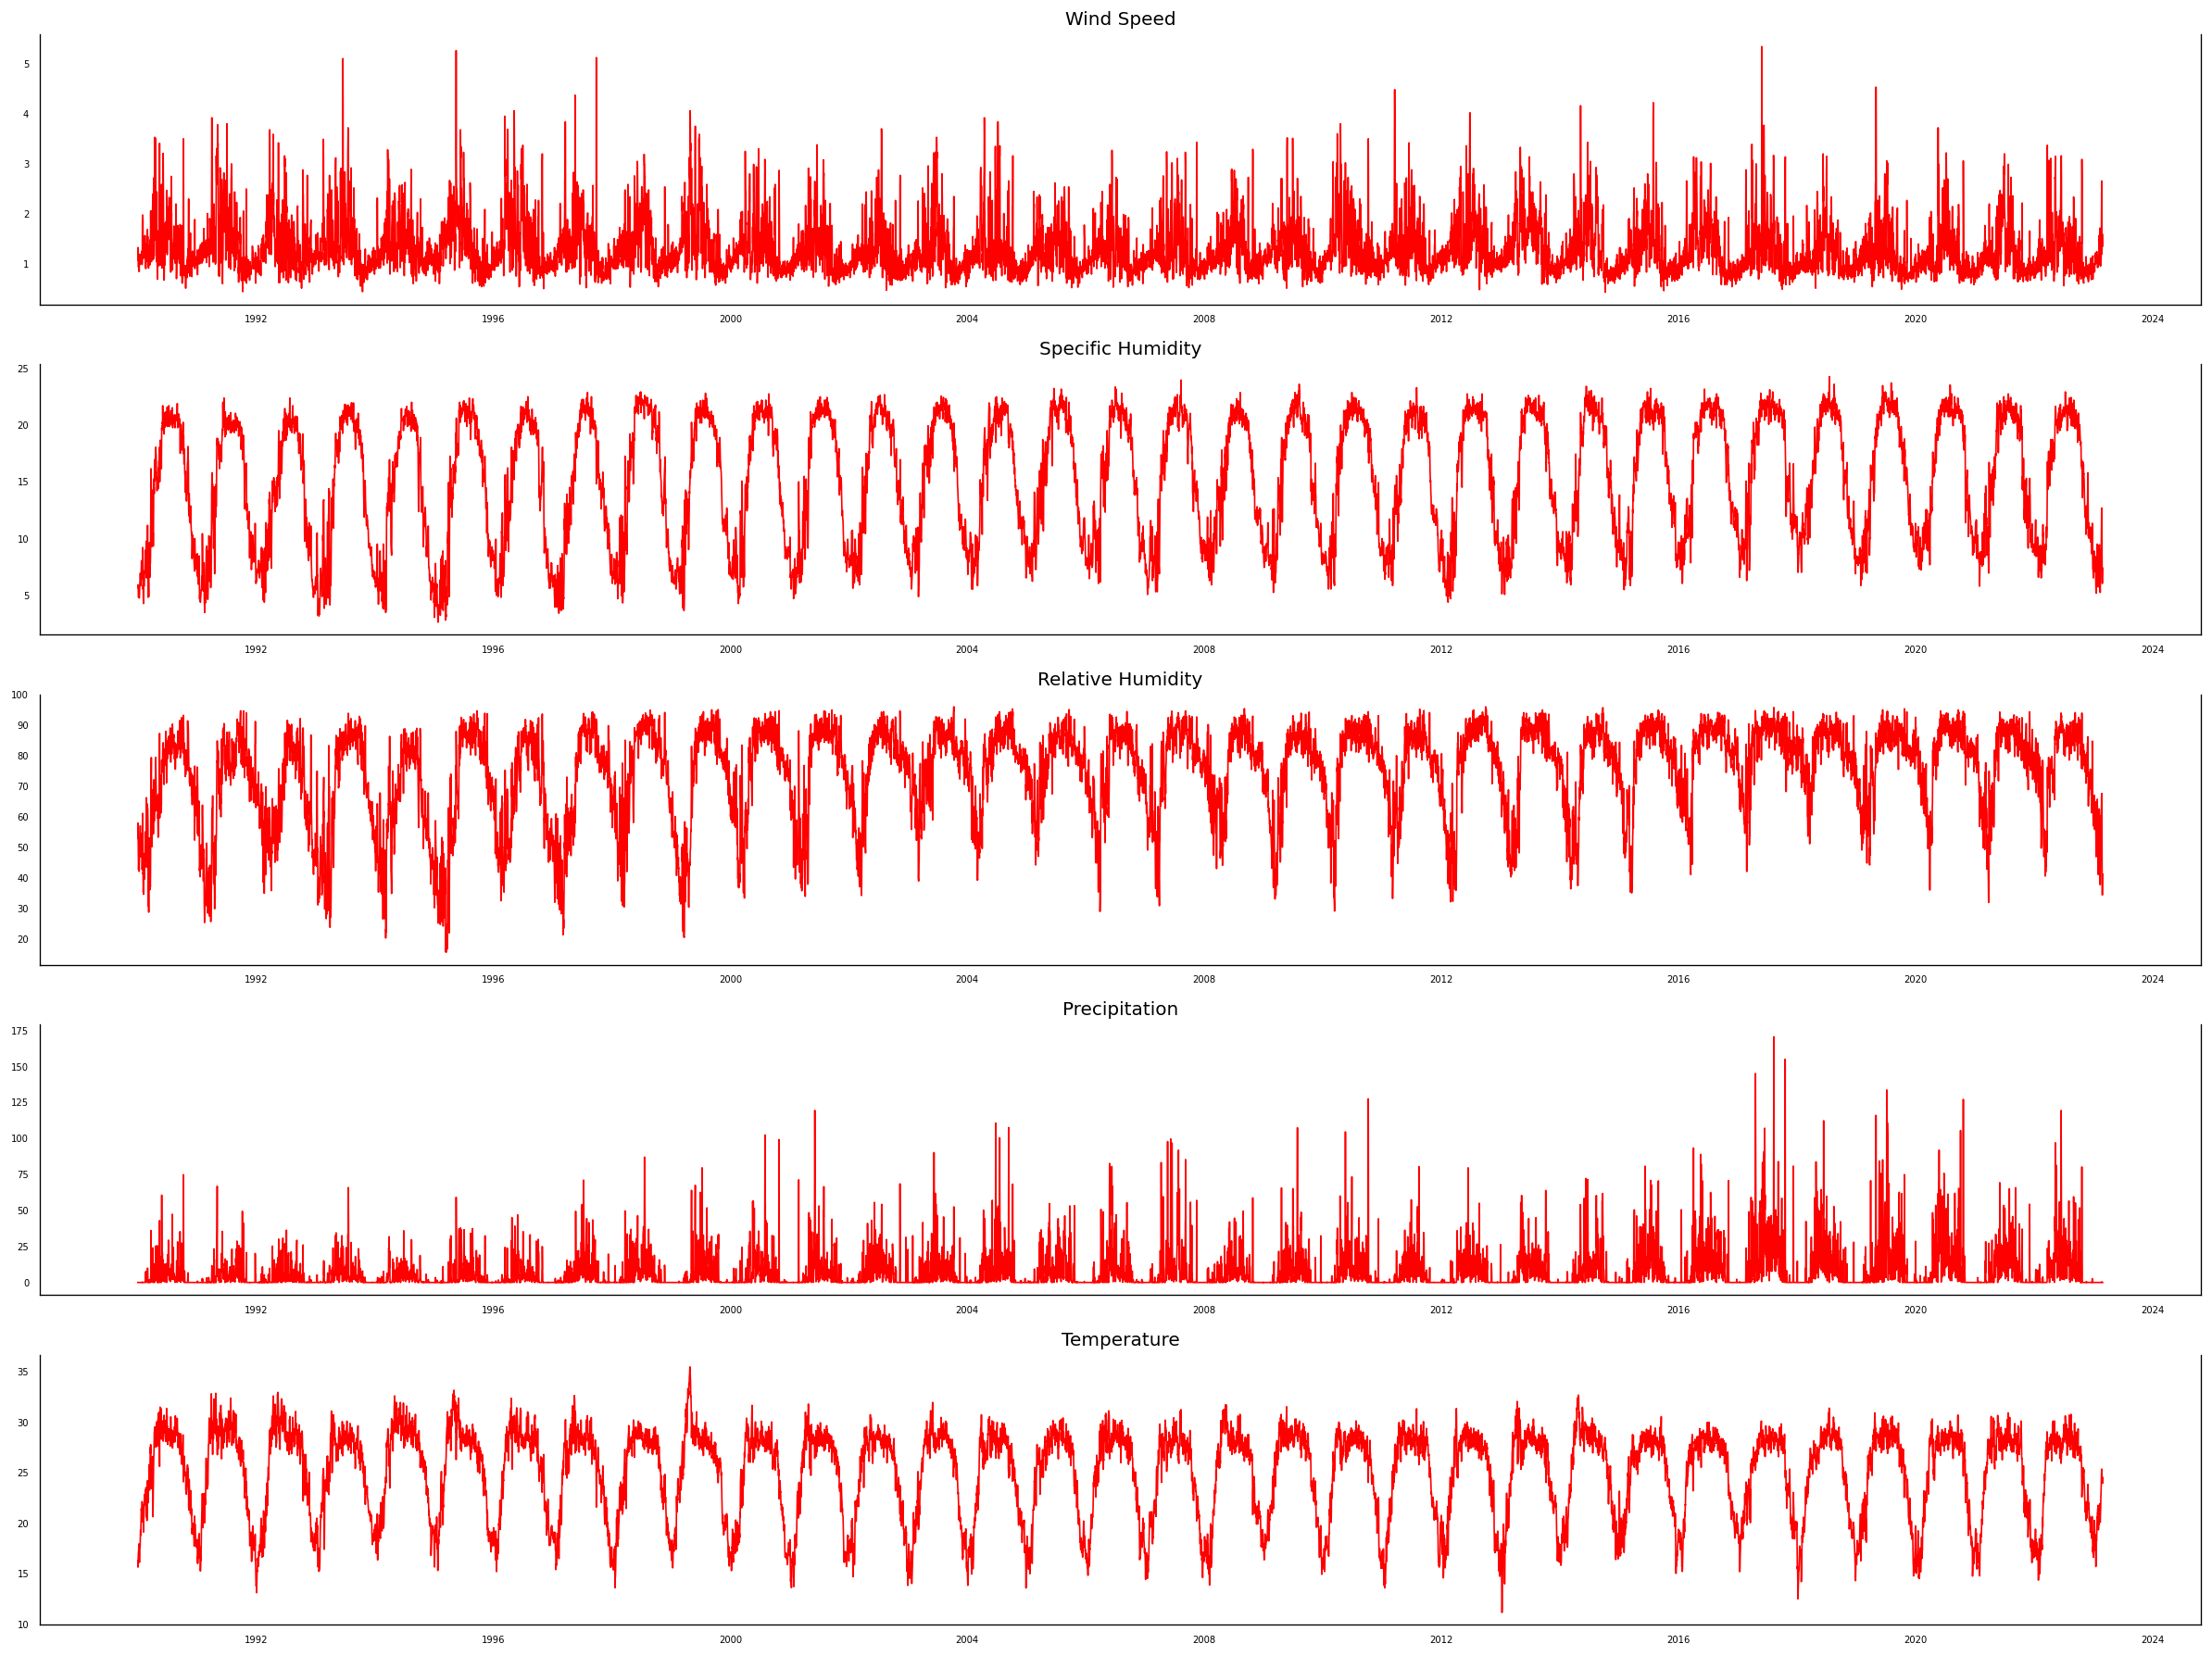

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(20, 15))
for i, ax in enumerate(axes.flatten()):
    d = timeseries[timeseries.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    ax.set_title(timeseries.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

Посмотрим на пропущенные значения.

In [ ]:
timeseries.isna().sum()

Wind Speed           0
Specific Humidity    0
Relative Humidity    0
Precipitation        0
Temperature          0
dtype: int64

Посмотрим на характеристики временных рядов.

In [ ]:
timeseries.describe()

,Wind Speed,Specific Humidity,Relative Humidity,Precipitation,Temperature
count,12113.000000,12113.000000,12113.000000,12113.000000,12113.000000
mean,1.311912,15.207111,74.635416,7.183984,25.038147
std,0.539321,5.529803,15.286193,13.126254,4.373427
min,0.440000,2.620000,15.810000,0.000000,11.190000
25%,0.950000,9.950000,65.250000,0.000000,21.430000
50%,1.150000,16.170000,79.620000,1.160000,26.930000
75%,1.520000,20.570000,86.560000,9.260000,28.400000
max,5.340000,24.290000,96.120000,170.630000,35.490000


In [ ]:
def decompose_col(column):
    rcParams['figure.figsize'] = 16, 8

    decompose = seasonal_decompose(timeseries[column], period=730)
    decompose.plot()
    plt.show()

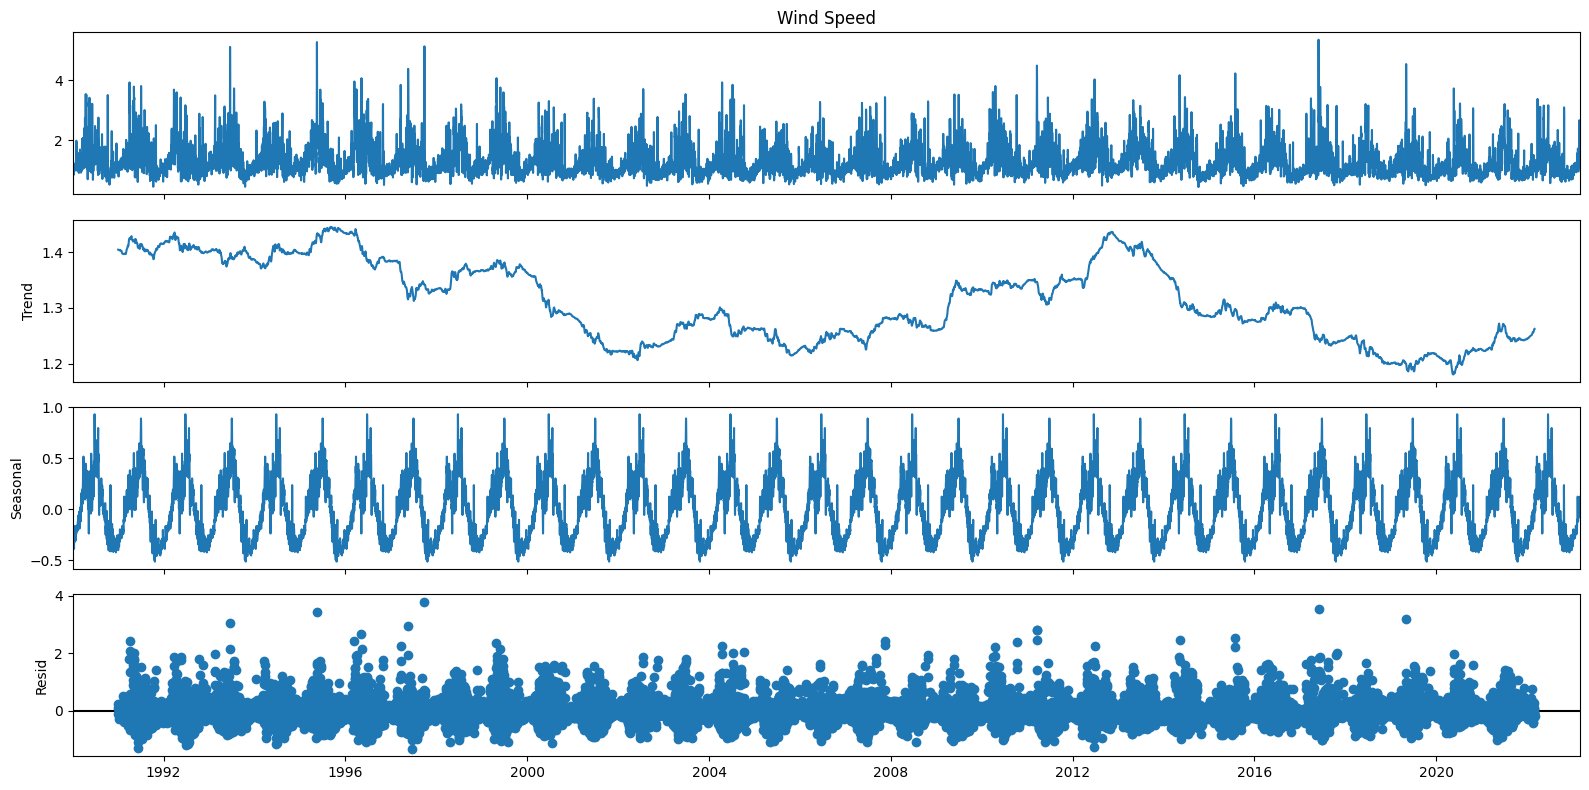

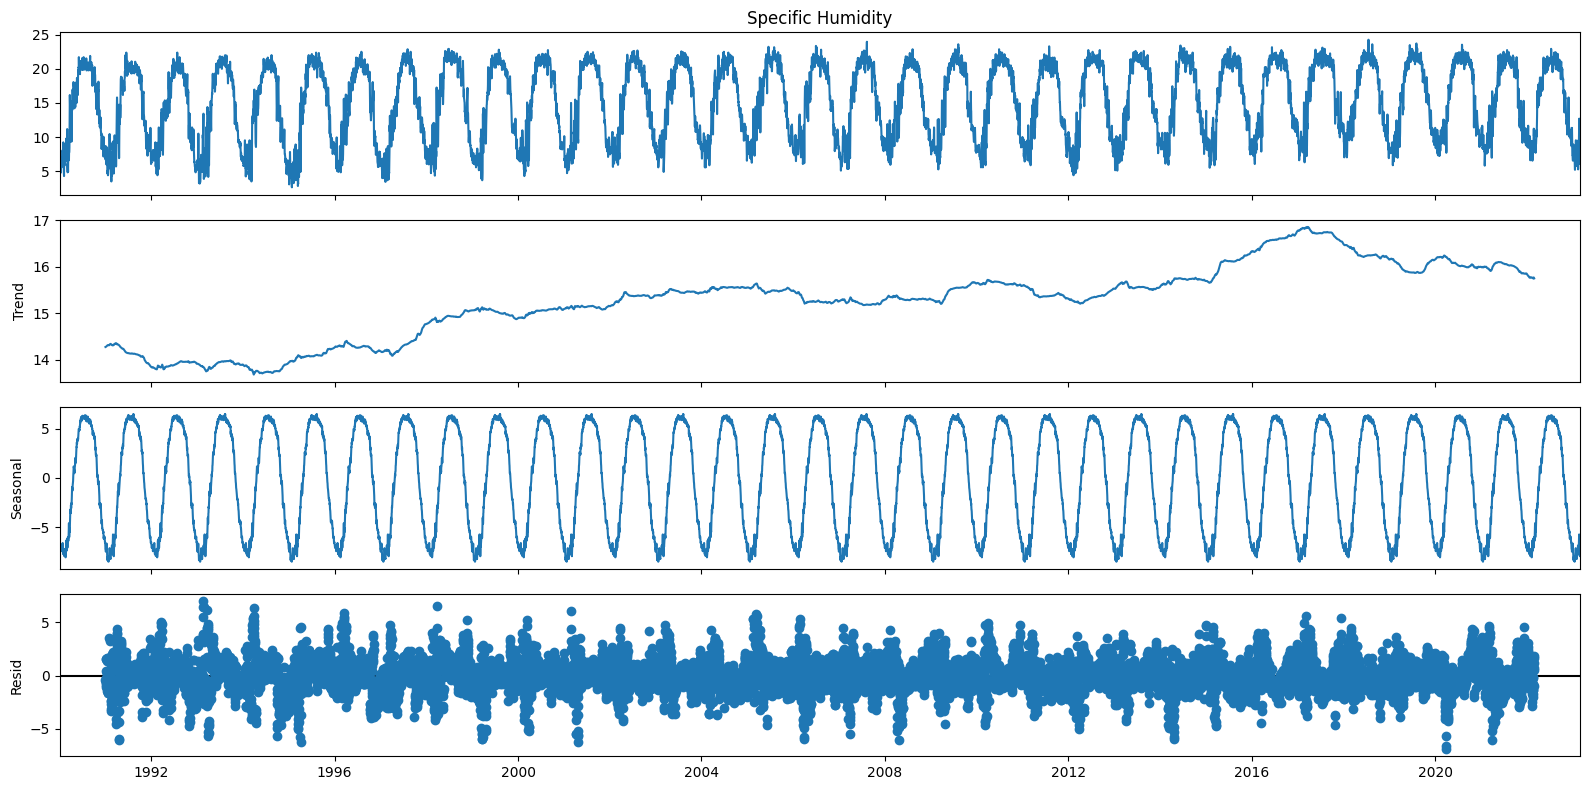

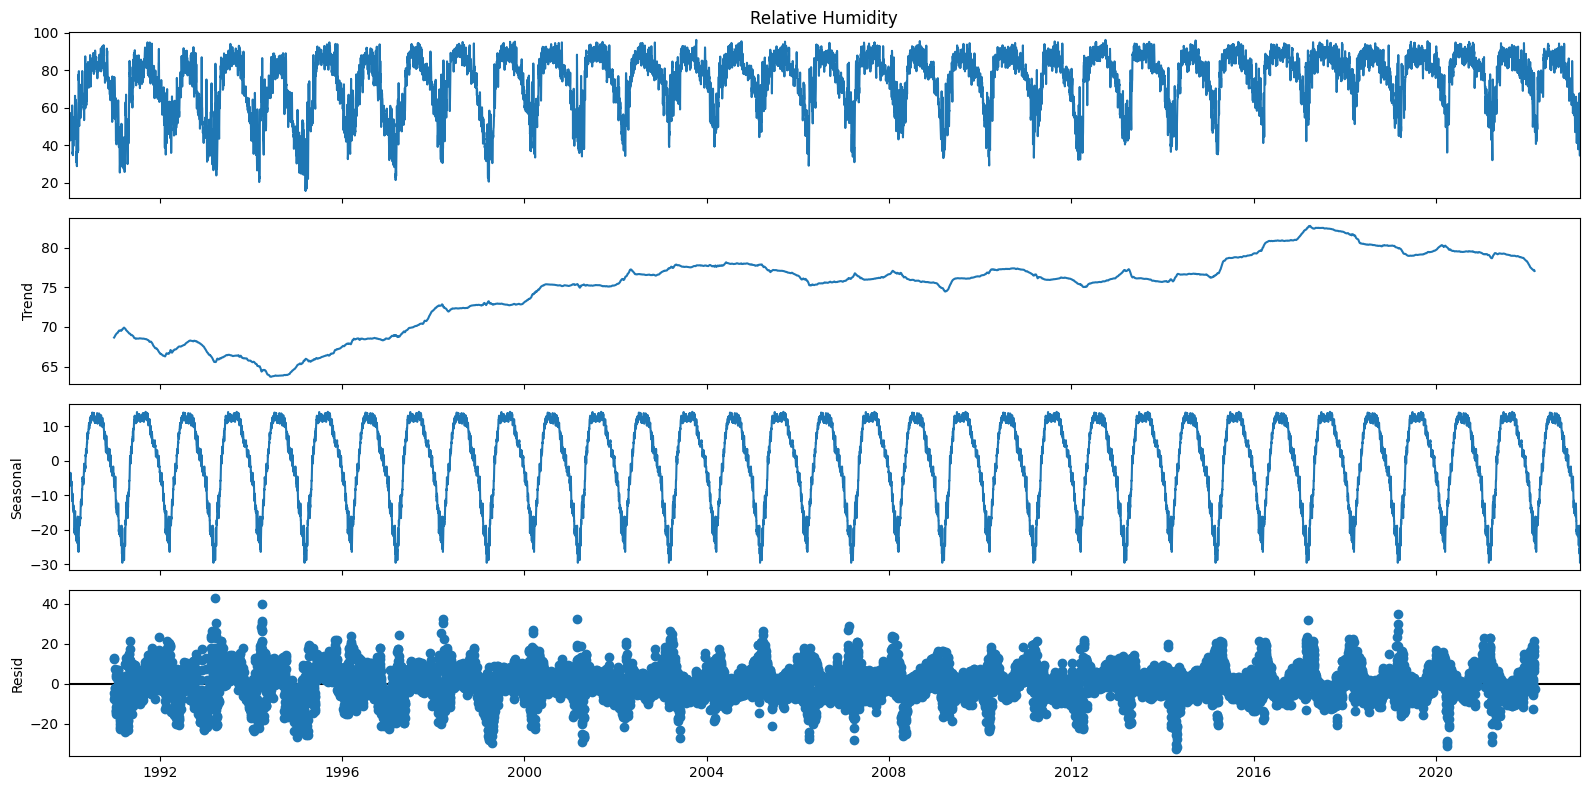

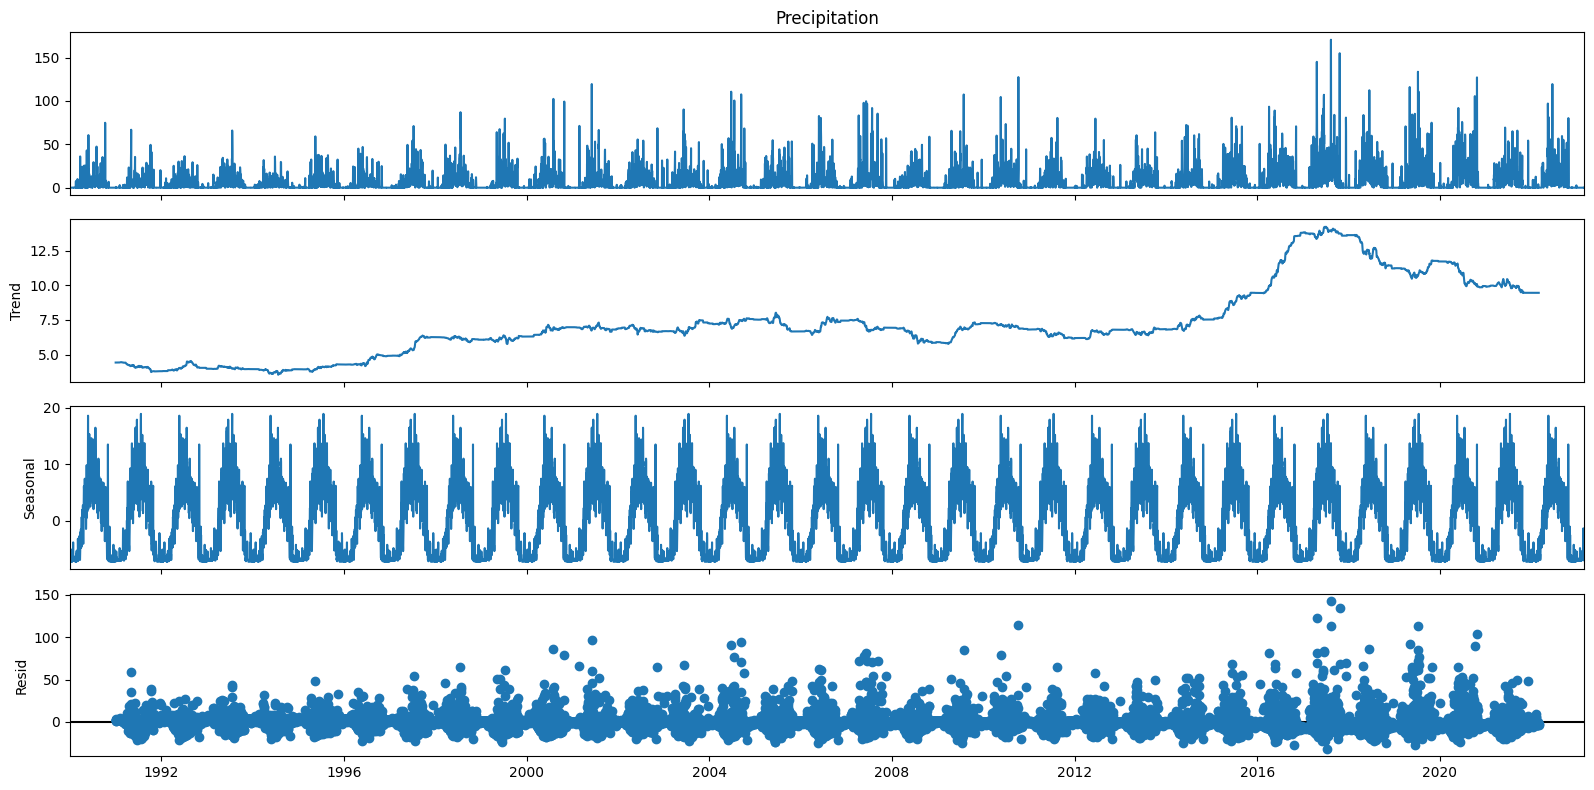

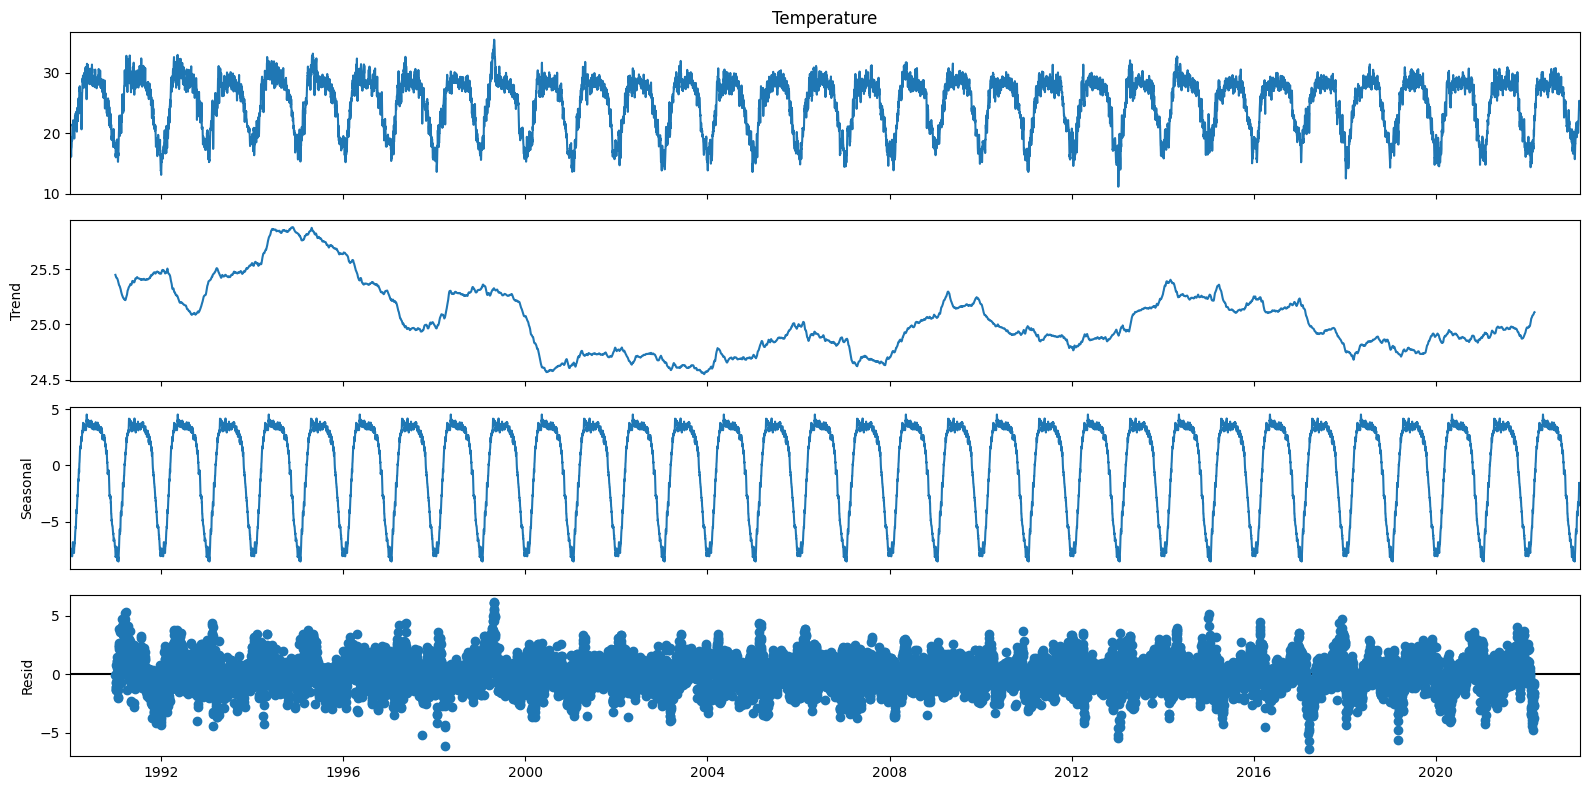

In [ ]:
for i in timeseries.columns:
    decompose_col(i)

Видим, что сезонность есть везде, трендов наблюдается везде кроме температуры и скорости ветра, остатки кажутся случайными, исследуем на стационарность.

In [ ]:
def dici_fuler(dataframe, name):
    alpha = 0.05

    print(f'Тест Дики-Фуллера ряда {name}:')
    dftest = adfuller(dataframe, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha * 100}%. Ряд не стационарный.")

In [ ]:
for i in timeseries.columns:
    dici_fuler(timeseries[i], i)

Тест Дики-Фуллера ряда Wind Speed:
Test Statistic                -8.826008e+00
p-value                        1.822831e-14
#Lags Used                     3.600000e+01
Number of Observations Used    1.207600e+04
Critical Value (1%)           -3.430892e+00
Critical Value (5%)           -2.861779e+00
Critical Value (10%)          -2.566897e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Specific Humidity:
Test Statistic                -1.000220e+01
p-value                        1.871386e-17
#Lags Used                     4.000000e+01
Number of Observations Used    1.207200e+04
Critical Value (1%)           -3.430892e+00
Critical Value (5%)           -2.861779e+00
Critical Value (10%)          -2.566897e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Relative Humidity:
Test Statistic                -8.216201e+00
p-value                        6.613990e-13
#Lags Used                     4.000000e+01
Number of Observati

Все ряды являются стационарными, что важно для прогнозирования классическими моделями.

Посмотрим на коинтеграцию и причинность рядов по Грейнджеру для проверки наличия причинной связи между рядами для использования VAR моделей.

In [ ]:
pairs = combinations(timeseries.columns, 2)

for pair in pairs:
    pair_data = timeseries[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между Wind Speed и Specific Humidity
Есть коинтеграция между Wind Speed и Relative Humidity
Есть коинтеграция между Wind Speed и Precipitation
Есть коинтеграция между Wind Speed и Temperature
Есть коинтеграция между Specific Humidity и Relative Humidity
Есть коинтеграция между Specific Humidity и Precipitation
Есть коинтеграция между Specific Humidity и Temperature
Есть коинтеграция между Relative Humidity и Precipitation
Есть коинтеграция между Relative Humidity и Temperature
Есть коинтеграция между Precipitation и Temperature


In [ ]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(timeseries, variables = timeseries.columns)
warnings.filterwarnings("default")
j_test

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


,Wind Speed_x,Specific Humidity_x,Relative Humidity_x,Precipitation_x,Temperature_x
Wind Speed_y,1.0,0.0,0.0,0.0000,0.0
Specific Humidity_y,0.0,1.0,0.0,0.0003,0.0
Relative Humidity_y,0.0,0.0,1.0,0.0004,0.0
Precipitation_y,0.0,0.0,0.0,1.0000,0.0
Temperature_y,0.0,0.0,0.0,0.0000,1.0


Все значения p-уровня значимости равны нулю, что подтверждает наличие причинной связи между рядами, значит можно использовать VAR модели, коинтегрированность всех рядов также это подтверждает.

#### Прогнозирование временных рядов.

In [11]:
def metrics(name, pred, true):
    print(f"Metrics for {name}")
    print("RMSE:", np.sqrt(mean_squared_error(pred, true)))
    print("MSE:", mean_squared_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(pred, true))
    print("MAE:", mean_absolute_error(pred, true))
    print("R2:", r2_score(pred, true))

Первая модель - VAR. Найдем лучший лаг для обучения.

In [ ]:
train = timeseries[:int(len(timeseries)*0.75)]
test = timeseries[int(len(timeseries)*0.75):len(timeseries)]

model = VAR(train)

orders = [i for i in range(1, 101)]
AIC_min = 1
BIC_min = 1
FPE_min = 1
HQC_min = 1

results = [[],[],[],[]]
for i in orders:
    result = model.fit(i)
    results[0].append(result.aic)
    results[1].append(result.bic)
    results[2].append(result.fpe)
    results[3].append(result.hqic)

best_pos = [np.argmin(results[0]),np.argmin(results[1]),np.argmin(results[2]),np.argmin(results[3])]
print(best_pos)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[12, 4, 12, 8]


Лаг 12 показал себя лучшим для двух из четырёх критериев, значит берем его.

In [ ]:
model = VAR(train)
model_fit = model.fit(12)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)].to_numpy())
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_train, Y_train

def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)].to_numpy())
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_test, Y_test

In [ ]:
X_train, Y_train = create_train_dataset(train, 12)
X_test, Y_test = create_test_dataset(test, 12)

In [ ]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fit.forecast(y=i,steps=1))

In [ ]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

In [ ]:
def plot_and_metrics(true, pred, train):
    for i, col in enumerate(timeseries.columns):
        Y_true = true[:, :, i]
        Y_pred = pred[:, :, i]
        Y_train = train[:, :, i]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{col} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        metrics(col, Y_true, Y_pred)

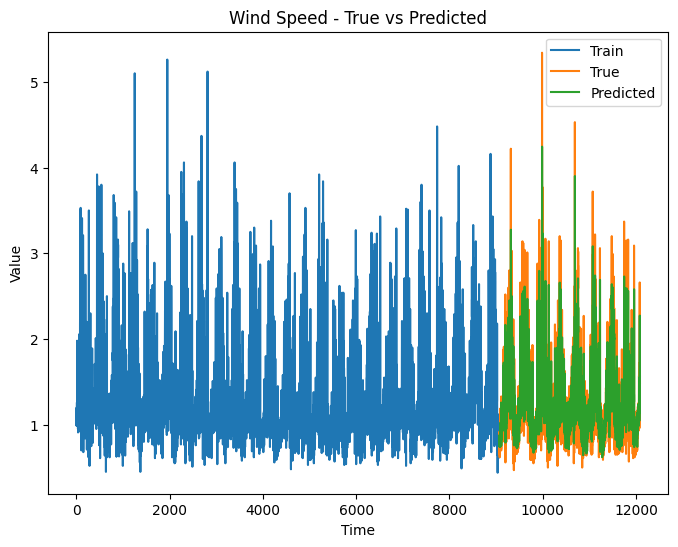

Metrics for Wind Speed
RMSE: 0.3346976945158619
MSE: 0.11202254671423321
MAPE: 0.18564717125085142
MAE: 0.22673456426579644
R2: 0.5670538522369101


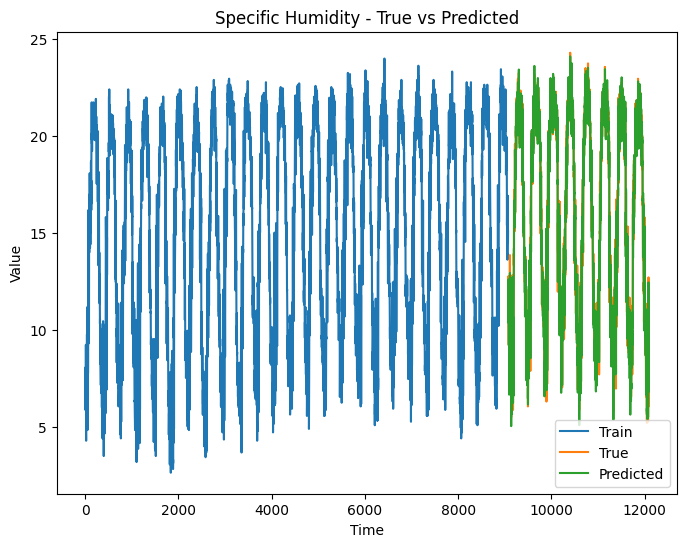

Metrics for Specific Humidity
RMSE: 0.7699622339730241
MSE: 0.59284184174473
MAPE: 0.04192738640081474
MAE: 0.5637080896453355
R2: 0.978280577358842


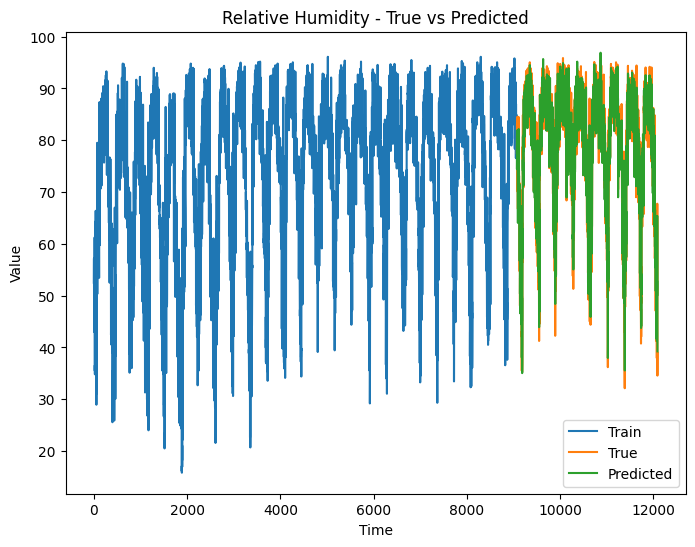

Metrics for Relative Humidity
RMSE: 3.962568090555367
MSE: 15.701945872287608
MAPE: 0.0397664211862844
MAE: 2.941007044146759
R2: 0.8874963940715545


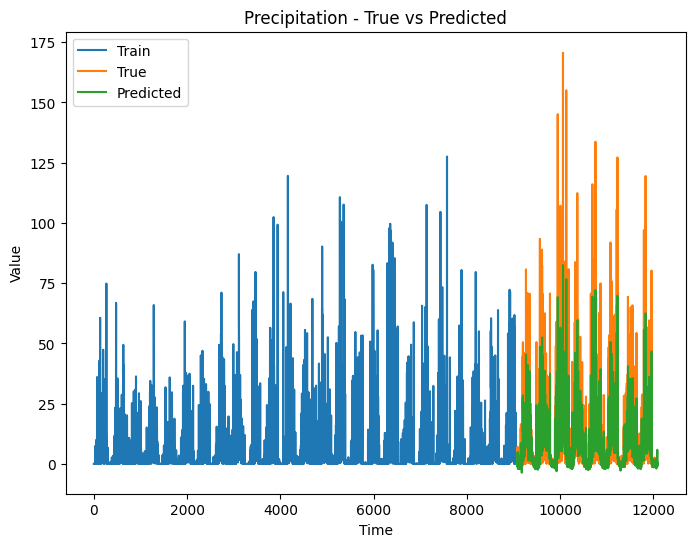

Metrics for Precipitation
RMSE: 13.506741440541038
MSE: 182.4320643416286
MAPE: 1629126678379048.0
MAE: 6.959539837409516
R2: 0.4112286745306867


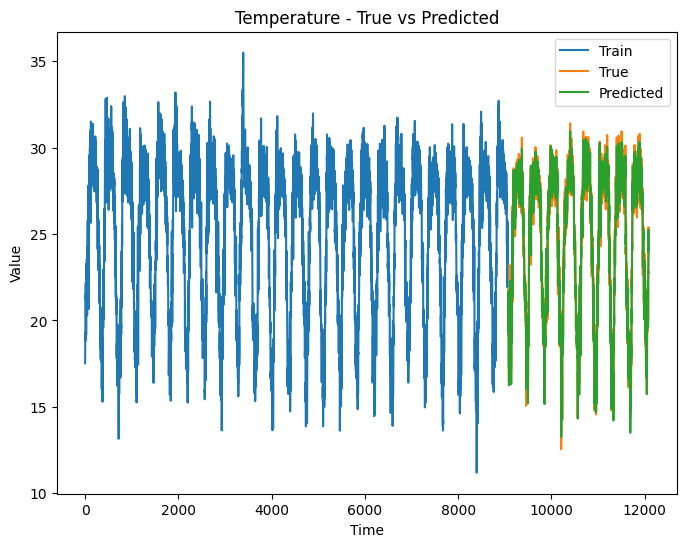

Metrics for Temperature
RMSE: 0.724935708583163
MSE: 0.5255317815789726
MAPE: 0.023711256580249772
MAE: 0.5632873423757863
R2: 0.9705116629440834


In [ ]:
plot_and_metrics(Y_test, Y_pred, Y_train)

Для трех рядов метрики отличные - они предсказываются очень точно, все метрики меньше единицы, а R2 очень близок к единице. Ряды скорости ветра и количества осадков предсказываются хуже, но в среднем метрики хорошие MAE, RMSE адекватные, такая ошибка, возможно, связана с тем, что эти ряды более случайны, чем другие.

Вторая модель - VARMA.

In [ ]:
train = timeseries[:int(len(timeseries)*0.75)]
test = timeseries[int(len(timeseries)*0.75):len(timeseries)]

Найдем оптимальные параметры с помощью auto_arima.

In [ ]:
from pmdarima import auto_arima

orders = []

for x in timeseries.columns:
    model = auto_arima(train[x], suppress_warnings=True, seasonal=True, stepwise=True, trace=True)
    best_order = model.get_params()['order']
    orders.append(best_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7576.012, Time=6.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9035.125, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8897.510, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8823.277, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9033.126, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7504.565, Time=5.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8245.644, Time=1.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7547.447, Time=4.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7499.071, Time=7.45 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7690.817, Time=3.91 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7504.952, Time=6.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=7499.466, Time=9.20 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=7544.228, Time=4.16 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=7502.565, Time=9.21 sec
 ARIMA(1,1,3)(0,0,0)[0]          

In [ ]:
print(orders)

[(2, 1, 2), (2, 1, 1), (2, 1, 1), (2, 1, 3), (4, 0, 1)]


Как самые часто встречаемые на своих позициях, были выбраны p=2, q=1.

In [ ]:
model = VARMAX(train, order=(2, 1)).fit()

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
result = model.forecast(steps=len(test))
result

,Wind Speed,Specific Humidity,Relative Humidity,Precipitation,Temperature
2014-11-15,0.873091,13.301840,77.192161,0.886600,22.825927
2014-11-16,0.939698,13.219726,76.518372,1.552850,22.827531
2014-11-17,1.004703,13.146094,76.121933,2.063355,22.772488
2014-11-18,1.047118,13.053457,75.645792,2.461778,22.724308
2014-11-19,1.076784,12.960400,75.117955,2.730335,22.691574
...,...,...,...,...,...
2023-02-25,1.303419,13.708952,71.099741,5.135971,24.095133
2023-02-26,1.303419,13.708952,71.099741,5.135971,24.095133
2023-02-27,1.303419,13.708952,71.099741,5.135971,24.095133
2023-02-28,1.303419,13.708952,71.099741,5.135971,24.095133


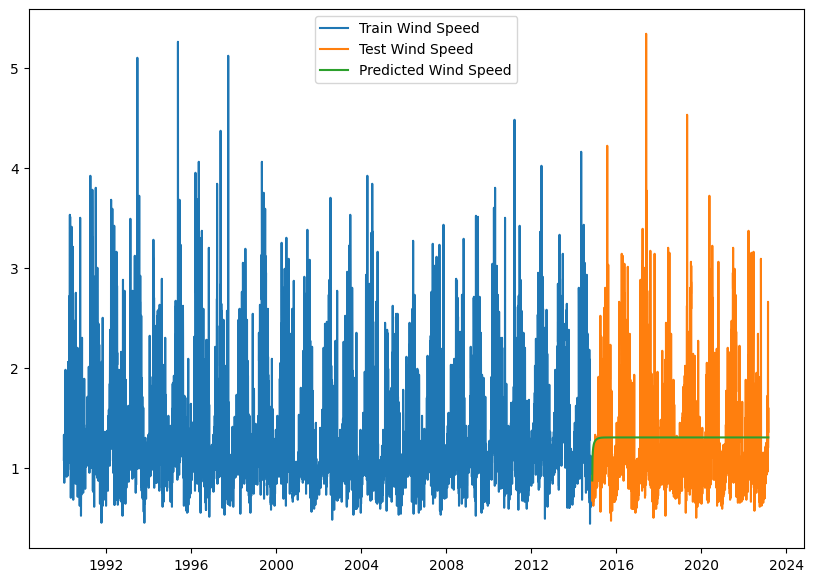

Metrics for Wind Speed
RMSE: 0.5109912319309775
MSE: 0.2611120391103381
MAPE: 0.3477512605121209
MAE: 0.3968044254526989
R2: -0.010664970661313555


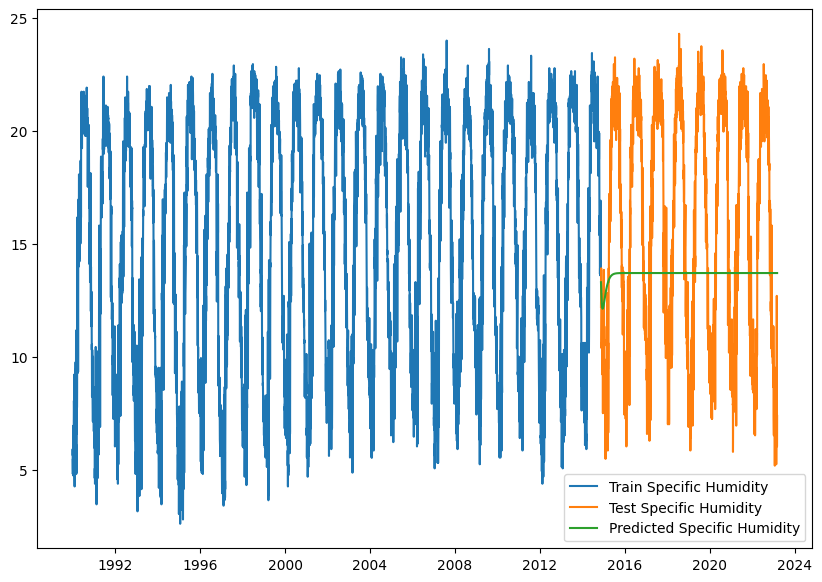

Metrics for Specific Humidity
RMSE: 5.659832809274082
MSE: 32.03370742893535
MAPE: 0.3369724989726549
MAE: 5.057178364080053
R2: -0.1746844523865323


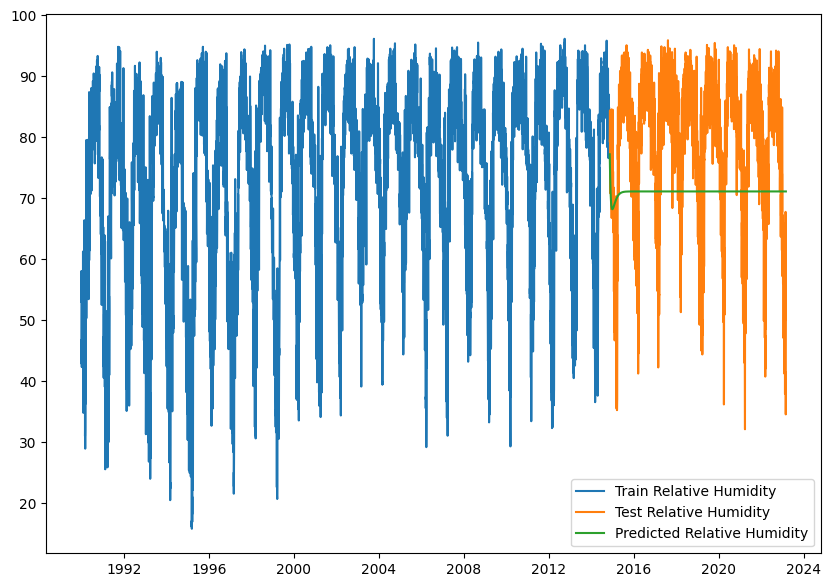

Metrics for Relative Humidity
RMSE: 14.315890490782419
MSE: 204.9447205440745
MAPE: 0.1653606848670803
MAE: 12.795477647489848
R2: -0.46909455210825346


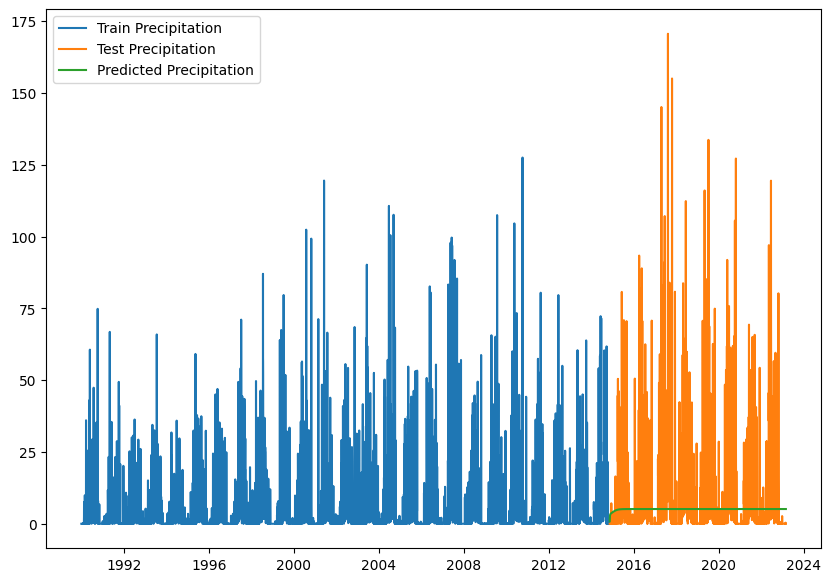

Metrics for Precipitation
RMSE: 18.424237691008784
MSE: 339.4525344947887
MAPE: 7776819991763982.0
MAE: 10.618220866584481
R2: -0.0985022551616137


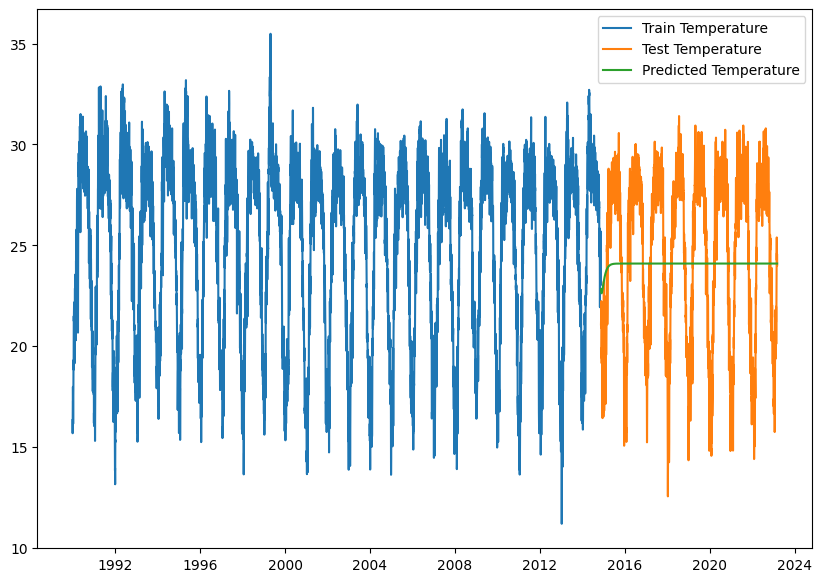

Metrics for Temperature
RMSE: 4.251358641112334
MSE: 18.07405029536051
MAPE: 0.16638778118150493
MAE: 3.8302834249608932
R2: -0.015060346968915228


In [ ]:
for i in timeseries.columns:
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(train[str(i)], label='Train '+ str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(result[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

    metrics(i, test[str(i)] , result[str(i)])

Здесь предсказания очень плохие, что видно по графикам, сначала модель пытается подстроиться под данные, но затем предсказывает просто прямой. Обычыные метрики (MAE, MSE) небольшие, что связано с относительно небольшой дисперсией рядов, здесь лишь R2 показывает плохие результаты у всех рядов, что логично, так как модель не объясняет практически ничего, а просто находит среднее.

### Нейросети

Первая модель - LSTM.

In [ ]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=3, batch_first=True)
        self.linear = nn.Linear(100, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
def data_split(ts, param="4", train_percentage=0.75):
    time_series = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(time_series) * train_percentage)
    train, test = time_series[:train_size], time_series[train_size:]
    return train, test, time_series

In [ ]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
def train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_l1, n_epochs, patience=10):
    y_pred_train = None
    y_pred_test = None
    min_test_rmse = np.inf
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_l1(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_l1(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_l1(y_pred, y_test))

            if test_rmse < min_test_rmse:
                min_test_rmse = test_rmse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')

            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch} epochs')
                break

    return y_pred_train, y_pred_test, model

In [ ]:
train, test, total = data_split(timeseries)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [ ]:
data_LSTM = timeseries.copy()

train, test, total = data_split(data_LSTM)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

model = AirModel()
optimizer = optim.Adamax(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 100

y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_fn, EPOCHS)

Epoch 0: train RMSE 4.4688, test RMSE 4.3351
Epoch 1: train RMSE 4.4207, test RMSE 4.2449
Epoch 2: train RMSE 4.4352, test RMSE 4.2779
Epoch 3: train RMSE 4.4196, test RMSE 4.2374
Epoch 4: train RMSE 1.6901, test RMSE 1.4519
Epoch 5: train RMSE 1.0210, test RMSE 0.9312
Epoch 6: train RMSE 0.8773, test RMSE 0.7926
Epoch 7: train RMSE 0.8715, test RMSE 0.7970
Epoch 8: train RMSE 1.2990, test RMSE 1.2071
Epoch 9: train RMSE 0.9180, test RMSE 0.7912
Epoch 10: train RMSE 0.8799, test RMSE 0.7983
Epoch 11: train RMSE 0.8701, test RMSE 0.7857
Epoch 12: train RMSE 0.8813, test RMSE 0.7714
Epoch 13: train RMSE 1.1441, test RMSE 1.1225
Epoch 14: train RMSE 0.9885, test RMSE 0.8898
Epoch 15: train RMSE 1.0744, test RMSE 1.0516
Epoch 16: train RMSE 0.9539, test RMSE 0.8141
Epoch 17: train RMSE 0.9832, test RMSE 0.9410
Epoch 18: train RMSE 0.8545, test RMSE 0.7686
Epoch 19: train RMSE 0.8662, test RMSE 0.7732
Epoch 20: train RMSE 0.8750, test RMSE 0.8214
Epoch 21: train RMSE 0.9045, test RMSE 0.855

LSTM metrics: 
Metrics for Temperature
RMSE: 0.76193565
MSE: 0.5805459
MAPE: 2.4840857833623886
MAE: 0.58715224
R2: 0.96399196990173


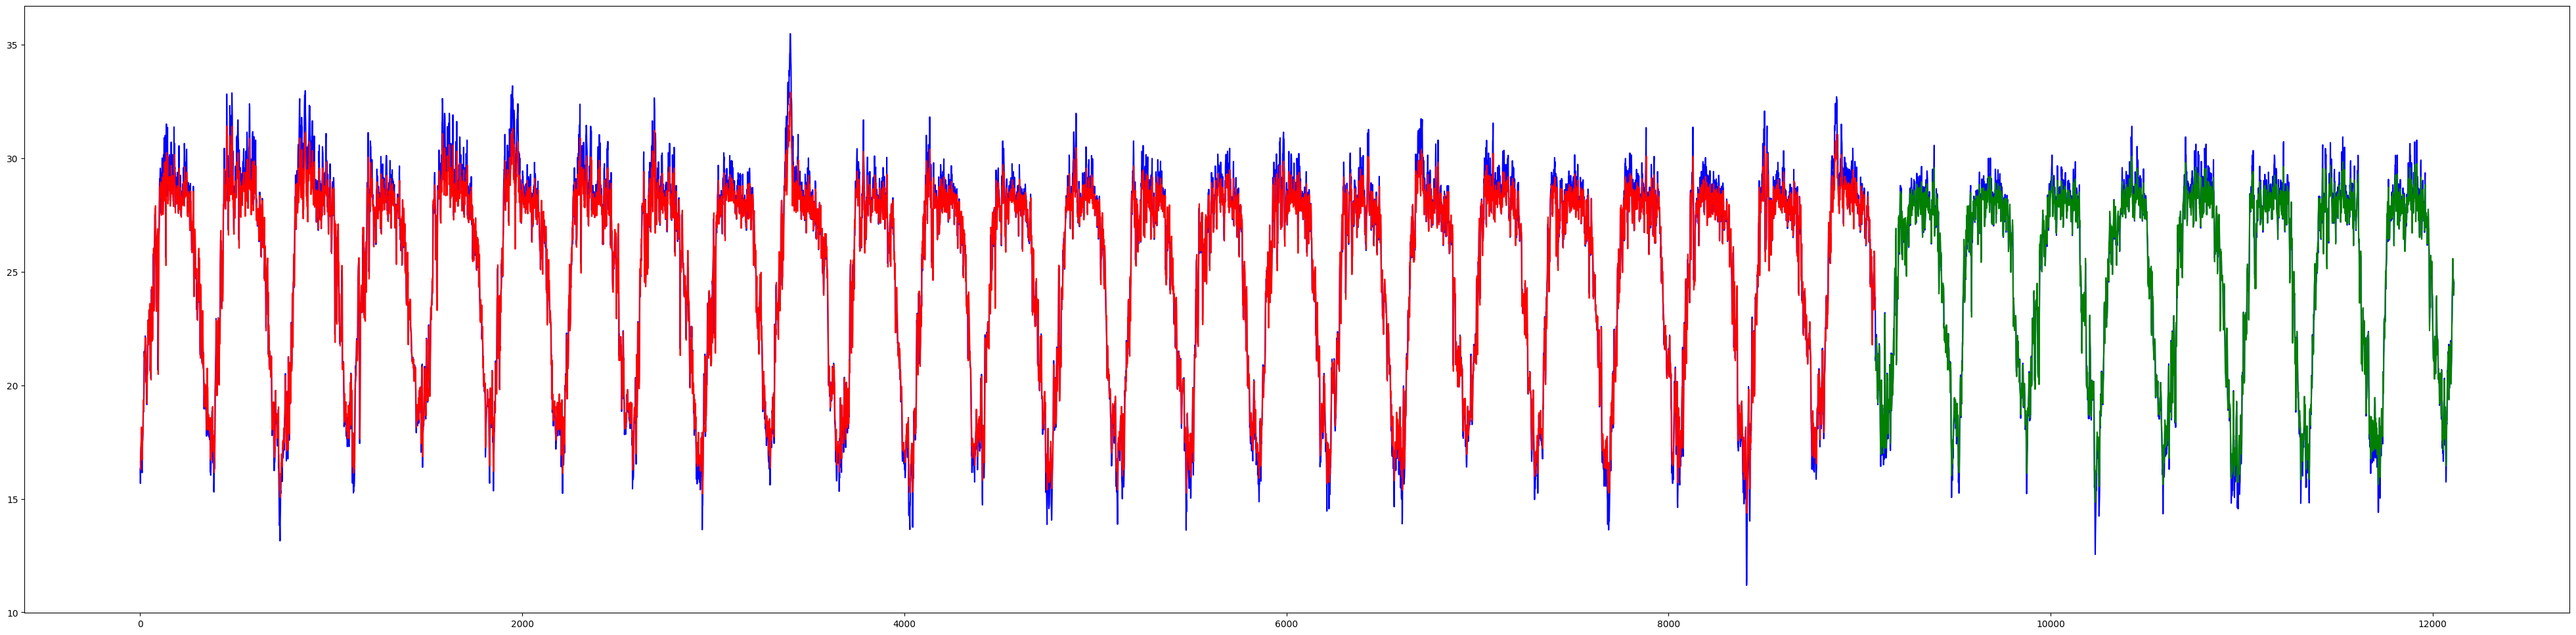

In [ ]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [50, 12]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

def validate_on_auto_measurement(model):
    valid_train, valid_test, valid_total = data_split(timeseries)
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred

    print("LSTM metrics: ")
    y_pred_test = pd.DataFrame(y_pred_test.flatten().detach().numpy())[0]
    y_test = pd.DataFrame(y_test.flatten().detach().numpy())[0]
    metrics('Temperature', y_pred_test, y_test)
    plot_train_n_pred(X_train, X_test, valid_total, model)

validate_on_auto_measurement(model)

Все метрики отличные, R2 близко к единице, остальные меньше 1, нейросеть хорошо выучила зависимости, даже учитывая ее простую структуру, и малое количество эпох, если настроить ее еще лучше, предсказания будут практически идеальными.

Вторая модель - GRU.

In [ ]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=100, num_layers=3, batch_first=True)
        self.linear = nn.Linear(100, 1)
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [ ]:
def data_split(ts, param="4", train_percentage=0.75):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

In [ ]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
def train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_l1, n_epochs, patience=10):
    y_pred_train = None
    y_pred_test = None
    min_test_rmse = np.inf
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_l1(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_l1(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_l1(y_pred, y_test))

            if test_rmse < min_test_rmse:
                min_test_rmse = test_rmse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')

            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch} epochs')
                break

    return y_pred_train, y_pred_test, model

In [ ]:
data_GRU = timeseries.copy()

train, test, total = data_split(data_GRU)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

model = GRUModel()
optimizer = optim.Adamax(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 100

y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_fn, EPOCHS)

Epoch 0: train RMSE 4.4188, test RMSE 4.2364
Epoch 1: train RMSE 1.2277, test RMSE 1.0674
Epoch 2: train RMSE 1.1486, test RMSE 1.0074
Epoch 3: train RMSE 0.8693, test RMSE 0.7802
Epoch 4: train RMSE 0.9462, test RMSE 0.8823
Epoch 5: train RMSE 1.4435, test RMSE 1.3264
Epoch 6: train RMSE 1.1887, test RMSE 1.0967
Epoch 7: train RMSE 1.0132, test RMSE 0.9035
Epoch 8: train RMSE 1.5704, test RMSE 1.4967
Epoch 9: train RMSE 0.9286, test RMSE 0.8370
Epoch 10: train RMSE 1.1868, test RMSE 1.0947
Epoch 11: train RMSE 1.0865, test RMSE 1.0059
Epoch 12: train RMSE 1.5654, test RMSE 1.4909
Epoch 13: train RMSE 1.0529, test RMSE 0.9696
Early stopping triggered after 13 epochs


GRU metrics: 
Metrics for Temperature
RMSE: 0.96958756
MSE: 0.9401001
MAPE: 3.4663666039705276
MAE: 0.79174215
R2: 0.947678327421417


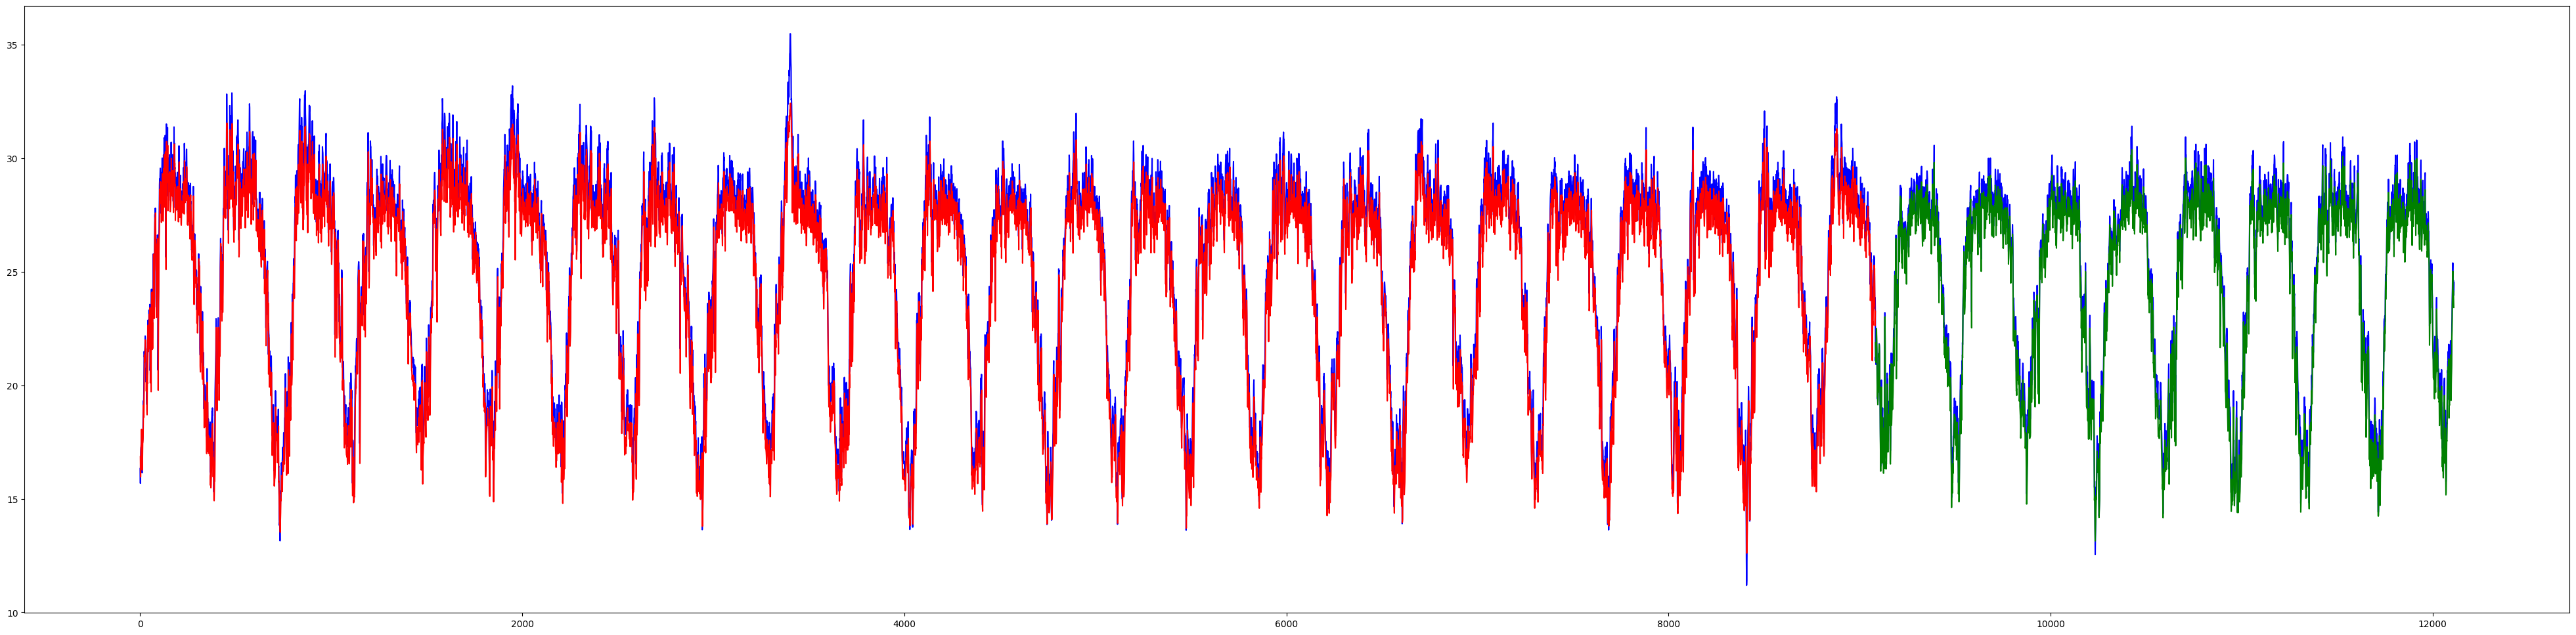

In [ ]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [50, 12]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

def validate_on_auto_measurement(model):
    valid_train, valid_test, valid_total = data_split(timeseries)
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred

    print("GRU metrics: ")
    y_pred_test = pd.DataFrame(y_pred_test.flatten().detach().numpy())[0]
    y_test = pd.DataFrame(y_test.flatten().detach().numpy())[0]
    metrics('Temperature', y_pred_test, y_test)
    plot_train_n_pred(X_train, X_test, valid_total, model)

validate_on_auto_measurement(model)

Здесь метрики немного хуже, чем у предыдущей модели, но все равно на том же уровне MSE, MAE меньше единицы, R2 близко к единице, учитывая достаточно слабый подбор гиперпараметров, нейроси показывают себя удивительно хорошо.

Третья модель - TCN.

In [20]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tcn import TCN

df = pd.DataFrame()
df['Temperature'] = timeseries['Temperature']

lookback_window = 20

df = df.values

x, y = [], []
for i in range(lookback_window, len(df)):
    x.append(df[i - lookback_window:i])
    y.append(df[i])
x = np.array(x)
y = np.array(y)

x_train = x[0:9500]
y_train = y[0:9500]
x_test = x[9500:]
y_test = y[9500:]

i = Input(shape=(lookback_window, 1))
m = TCN()(i)
m = Dense(1, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])

model.summary()

model.compile('adam', 'mae')

model.fit(x_train, y_train, epochs=150, verbose=0)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 tcn_1 (TCN)                 (None, 64)                136256    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 136321 (532.50 KB)
Trainable params: 136321 (532.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


82/82 [==============================] - 1s 7ms/step


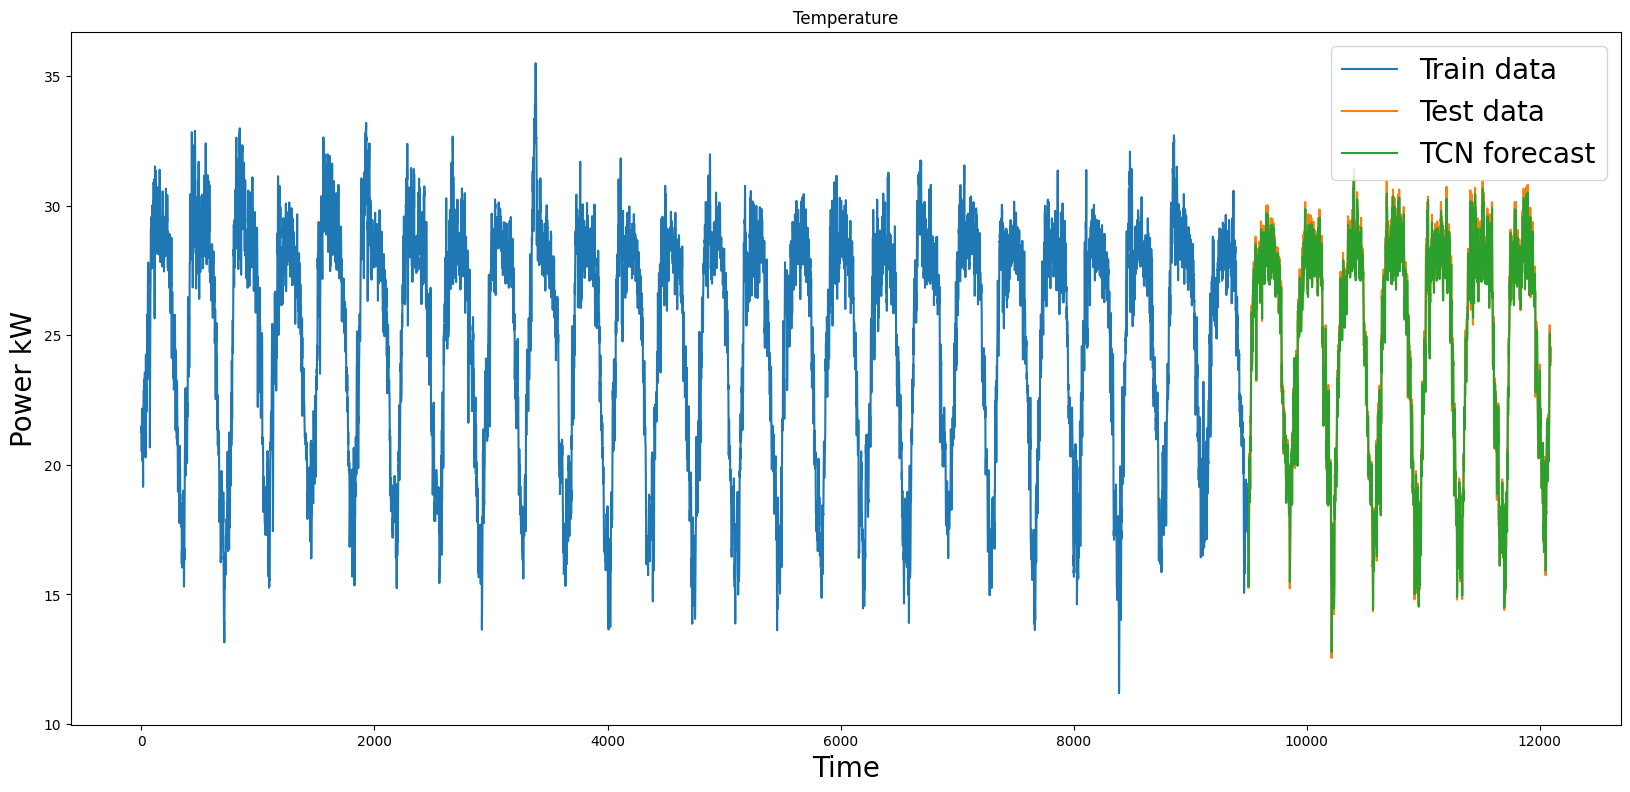

TCN metrics:
Metrics for Temperature
RMSE: 0.748337566378438
MSE: 0.560009113253203
MAPE: 0.024486129182841834
MAE: 0.5853689571811662
R2: 0.9686175254642463


In [22]:
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

plt.plot([i for i in range(0, size)], y_train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test, label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], y_pred, label='TCN forecast')
plt.legend(fontsize="20")
plt.title('Temperature')
plt.ylabel('Power kW', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()
print('TCN metrics:')
metrics('Temperature', y_test, y_pred)

TCN показала себя лучше чем другие модели, очень хорошие метрики, R2 примерно 0.97, MSE и MAE близки к 0.5 Предсказания практически не отличаются от настоящих данных.

### Вывод

Все модели показали себя отлично (кроме VARMAX, непонятно почему так себя ведет VARMAX, возможно плохой подбор параметров, плюс это единственная модель, которая училась дольше 10 минут). VAR показал себя хорошо, но не на всех рядах, нейросети показали себя хорошо даже с плохим подбором гиперпараметров и ненормализованными данными. Нейросети просты в настройке и, по крайней мере на небольшом датасете, учатся достаточно быстро для таких результатов. Также, если бы данных было больше, то нейросети показали бы себя еще лучше. Самой лучшей была TCN, она показала лучшие результаты среди нейросетей, и могла бы показать еще лучше.